<a href="https://colab.research.google.com/github/kathdevx/emotionalAI/blob/main/fine_tune_wav2vec2_base_960h.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip install datasets
!pip install transformers

     |████████████████████████████████| 311 kB 12.1 MB/s 
     |████████████████████████████████| 212 kB 52.7 MB/s 
     |████████████████████████████████| 1.1 MB 46.9 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 134 kB 44.1 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 52.7 MB/s 
     |████████████████████████████████| 271 kB 37.9 MB/s 
     |████████████████████████████████| 3.5 MB 12.0 MB/s 
     |████████████████████████████████| 6.8 MB 39.8 MB/s 
     |████████████████████████████████| 895 kB 44.7 MB/s 
     |████████████████████████████████| 596 kB 41.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from datasets import load_dataset, load_metric
import torchaudio
from transformers import AutoConfig, Wav2Vec2Processor
import os
from typing import Tuple
from transformers.file_utils import ModelOutput
import librosa
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss

from dataclasses import dataclass
from typing import Dict, List, Optional, Union
import torch
import shutil
import transformers
from datasets import Dataset
import numpy as np
from transformers import EvalPrediction
import pandas as pd

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Data Analysis

In [ ]:
td = pd.read_csv('/content/drive/MyDrive/Data/Train.csv')
label_mappings = {
    'A': 'Angry',
    'S': 'Sad',
    'H': 'Happy',
    'U': 'Surprise',
    'F': 'Fear',
    'D': 'Disgust',
    'C': 'Contempt',
    'N': 'Neutral',
    'O': 'Other',
    'X': 'Non Agreement'
}
for emotion_label, emotion in label_mappings.items():
    num_category = td[td['EmoClass'] == emotion_label]['EmoClass'].count()
    print(f'{emotion} labels: {num_category}')

Angry labels: 1839
Sad labels: 1681
Happy labels: 8564
Surprise labels: 2451
Fear labels: 969
Disgust labels: 1363
Contempt labels: 2179
Neutral labels: 16518
Other labels: 475
Non Agreement labels: 8840


In [ ]:
vd = pd.read_csv('/content/drive/MyDrive/Data/Validation.csv')
label_mappings = {
    'A': 'Angry',
    'S': 'Sad',
    'H': 'Happy',
    'U': 'Surprise',
    'F': 'Fear',
    'D': 'Disgust',
    'C': 'Contempt',
    'N': 'Neutral',
    'O': 'Other',
    'X': 'Non Agreement'
}
for emotion_label, emotion in label_mappings.items():
    num_category = vd[td['EmoClass'] == emotion_label]['EmoClass'].count()
    print(f'{emotion} labels: {num_category}')

Angry labels: 726
Sad labels: 0
Happy labels: 3331
Surprise labels: 0
Fear labels: 386
Disgust labels: 534
Contempt labels: 854
Neutral labels: 1969
Other labels: 0
Non Agreement labels: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app


In [ ]:
import pandas as pd
from tqdm.notebook import tqdm_notebook

split_set = ['Train','Validation']
ceiling_value = [2500, 700]
fracs = [0.4, 0.4]
for split, sample_size in zip(split_set, fracs):
    print(f"{'-'*20} {split} Dataset {'-'*20}")
    split_df = pd.read_csv('/content/drive/MyDrive/Data/'+split+'.csv')
    print(f'Initial size: {len(split_df)}')
    split_df.drop(split_df.index[split_df['EmoClass'] == 'X'], inplace = True)
    split_df.drop(split_df.index[split_df['EmoClass'] == 'O'], inplace = True)
    print(f'Size after removing X (Non Agreement) and O (Other) labels: {len(split_df)}')

    split_df_sample = split_df.groupby('EmoClass', group_keys=False).apply(lambda x: x.sample(frac=sample_size)) # Get proportionate labels
    split_df_sample = split_df_sample.reset_index(drop=True)
    split_df_sample['Path'] = split_df_sample['Path'].str.replace('Podcast Data/Audios', '/content/drive/MyDrive/Data/Audio Files')
    bad_idxs=[]
    print(f'{round(sample_size*100)}% Sample size: {len(split_df_sample)}')
    for i in tqdm_notebook(range(len(split_df_sample.index))):
        try:
            with open(split_df_sample.loc[i, 'Path'], 'r') as f:
                pass
        except FileNotFoundError:
            bad_idxs.append(i)
    split_df_sample = split_df_sample.drop(bad_idxs)     
    split_df_sample = split_df_sample.reset_index(drop=True)
    print(f'Size after removing corrupt/missing files: {len(split_df_sample)}')
    split_df_sample = split_df_sample[['FileName', 'EmoClass', 'Path']].copy()
    new_fname = f'/content/drive/MyDrive/Data/{split}_failed_even_dataset.csv'
    split_df_sample.to_csv(new_fname, index=False)

-------------------- Train Dataset --------------------
Initial size: 44879
Size after removing X (Non Agreement) and O (Other) labels: 35564
40% Sample size: 14226


  0%|          | 0/14226 [00:00<?, ?it/s]

Size after removing corrupt/missing files: 13802
-------------------- Validation Dataset --------------------
Initial size: 7800
Size after removing X (Non Agreement) and O (Other) labels: 6272
40% Sample size: 2509


  0%|          | 0/2509 [00:00<?, ?it/s]

Size after removing corrupt/missing files: 2447


Text(0.5, 1.0, 'Validation Dataset after Proportionate Sampling (Uneven)')

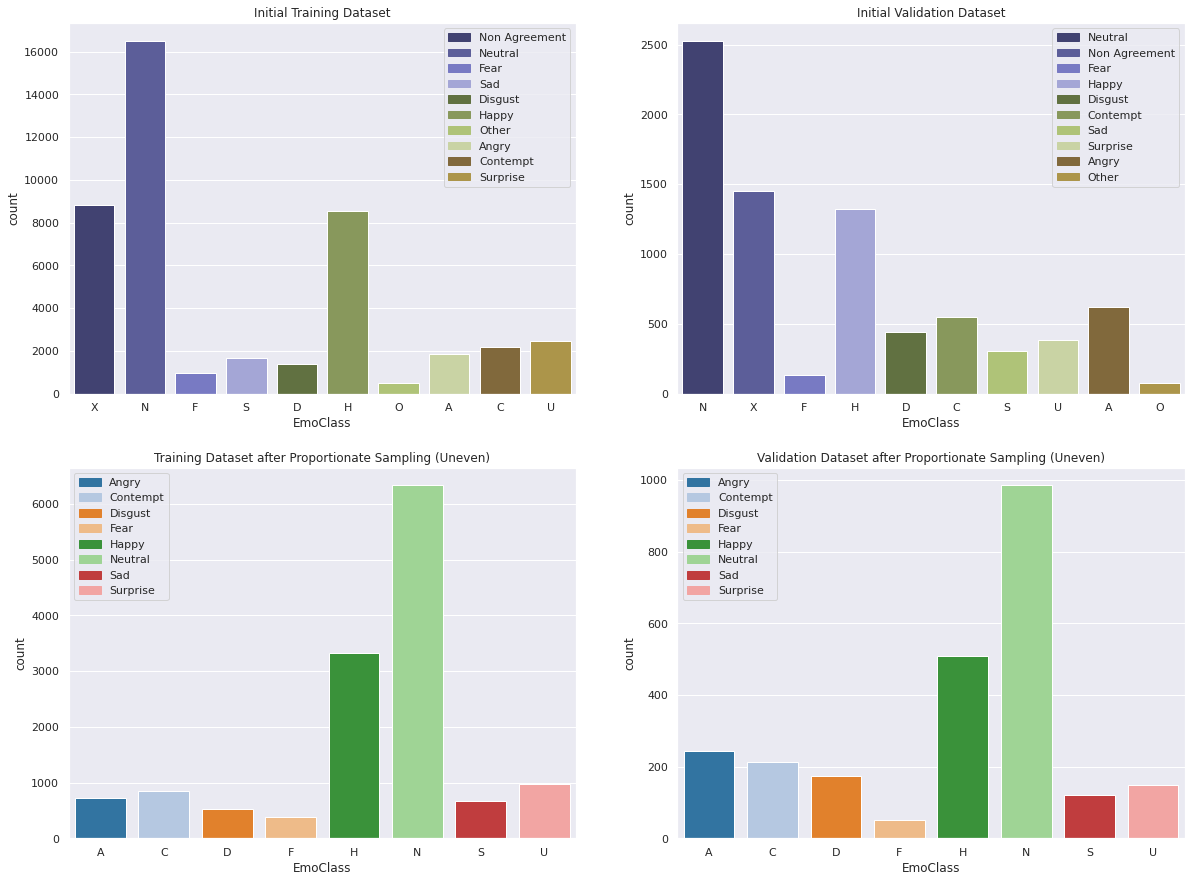

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

original_train_label_mappings = {
    'X': 'Non Agreement',
    'N': 'Neutral',
    'F': 'Fear',
    'S': 'Sad',
    'D': 'Disgust',
    'H': 'Happy',
    'O': 'Other',
    'A': 'Angry',
    'C': 'Contempt',
    'U': 'Surprise'
}

original_validation_label_mappings = {
    'N': 'Neutral',
    'X': 'Non Agreement',
    'F': 'Fear',
    'H': 'Happy',
    'D': 'Disgust',
    'C': 'Contempt',
    'S': 'Sad',
    'U': 'Surprise',
    'A': 'Angry',
    'O': 'Other'
}


refained_label_mappings = {
    'A': 'Angry',
    'C': 'Contempt',
    'D': 'Disgust',
    'F': 'Fear',
    'H': 'Happy',
    'N': 'Neutral',
    'S': 'Sad',
    'U': 'Surprise'
}

color_tab20b=['#414271', '#5c5e99', '#787ac3', '#a4a6d6', '#617141', '#88985c', '#afc378', '#c9d3a4', '#81693c', '#ac954a']

td = pd.read_csv('/content/drive/MyDrive/Data/Train.csv')
vd = pd.read_csv('/content/drive/MyDrive/Data/Validation.csv')


sns.set_theme(style="darkgrid")
f, axs = plt.subplots(2,2,figsize=(20,15))

labels = list(original_train_label_mappings.values())
handles = [plt.Rectangle((0,0),1,1, color=color_tab20b[label]) for label in range(len(labels))]
plt.subplot(2, 2, 1)
axs = sns.countplot(x=td['EmoClass'], data=td, palette='tab20b')
plt.legend(handles, labels, loc='upper right')
plt.title('Initial Training Dataset')

labels = list(original_validation_label_mappings.values())
handles = [plt.Rectangle((0,0),1,1, color=color_tab20b[label]) for label in range(len(labels))]
plt.subplot(2, 2, 2)
axs = sns.countplot(x=vd['EmoClass'], data=vd, palette='tab20b')
plt.legend(handles, labels, loc='upper right')
plt.title('Initial Validation Dataset')

color_tab20=['#3274a1', '#b5c8e1', '#e1812c', '#eebb89', '#3a923a', '#9fd495', '#c03d3e', '#f2a5a3']
labels = list(label_mappings.values())
handles = [plt.Rectangle((0,0),1,1, color=color_tab20[label]) for label in range(len(labels))]


td_fail = pd.read_csv('/content/drive/MyDrive/Data/Train_failed_even_dataset.csv')
vd_fail = pd.read_csv('/content/drive/MyDrive/Data/Validation_failed_even_dataset.csv')

plt.subplot(2, 2, 3)
axs = sns.countplot(x=td_fail['EmoClass'], data=td_fail, palette='tab20')
plt.legend(handles, labels, loc='upper left')
plt.title('Training Dataset after Proportionate Sampling (Uneven)')

plt.subplot(2, 2, 4)
axs = sns.countplot(x=vd_fail['EmoClass'], data=vd_fail, palette='tab20')
plt.legend(handles, labels, loc='upper left')
plt.title('Validation Dataset after Proportionate Sampling (Uneven)')

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm_notebook

split_set = ['Train', 'Validation']
ceiling_value = [2500, 700]
sample_size = 0.7
for split, ceiling in zip(split_set, ceiling_value):
    print(f"{'-'*20} {split} Dataset {'-'*20}")
    split_df = pd.read_csv('/content/drive/MyDrive/Data/'+split+'.csv')
    print(f'Initial size: {len(split_df)}')
    split_df.drop(split_df.index[split_df['EmoClass'] == 'X'], inplace = True)
    split_df.drop(split_df.index[split_df['EmoClass'] == 'O'], inplace = True)
    print(f'Size after removing X (Non Agreement) and O (Other) labels: {len(split_df)}')
    split_df = split_df.reset_index(drop=True)


    total_happy_idxs = split_df.index[split_df['EmoClass'] == 'H']
    split_df = split_df.drop(total_happy_idxs[ceiling:])     
    split_df = split_df.reset_index(drop=True)

    total_neutral_idxs = split_df.index[split_df['EmoClass'] == 'N']
    split_df = split_df.drop(total_neutral_idxs[ceiling:])     
    split_df = split_df.reset_index(drop=True)

    print(f'Size after removing excess H (Happy) and N (Neutral) labels: {len(split_df)}')

    split_df['Path'] = split_df['Path'].str.replace('Podcast Data/Audios', '/content/drive/MyDrive/Data/Audio Files')
    bad_idxs=[]
    for i in tqdm_notebook(range(len(split_df.index))):
        try:
            with open(split_df.loc[i, 'Path'], 'r') as f:
                pass
        except FileNotFoundError:
            bad_idxs.append(i)
    split_df = split_df.drop(bad_idxs)     
    split_df = split_df.reset_index(drop=True)
    print(f'Size after removing corrupt/missing files: {len(split_df)}')
    split_df = split_df.groupby('EmoClass', group_keys=False).apply(lambda x: x.sample(frac=sample_size))

    print(f'{round(sample_size*100)}%  sample size: {len(split_df)}')
    split_df = split_df[['FileName', 'EmoClass', 'Path']].copy()
    new_fname = f'/content/drive/MyDrive/Data/{split}_even_dataset.csv'
    split_df.to_csv(new_fname, index=False)

-------------------- Train Dataset --------------------
Initial size: 44879
Size after removing X (Non Agreement) and O (Other) labels: 35564
Size after removing excess H (Happy) and N (Neutral) labels: 15482


  0%|          | 0/15482 [00:00<?, ?it/s]

Size after removing corrupt/missing files: 14488
70%  sample size: 10141
-------------------- Validation Dataset --------------------
Initial size: 7800
Size after removing X (Non Agreement) and O (Other) labels: 6272
Size after removing excess H (Happy) and N (Neutral) labels: 3823


  0%|          | 0/3823 [00:00<?, ?it/s]

Size after removing corrupt/missing files: 3678
70%  sample size: 2573


Text(0.5, 1.0, 'Even Validation Dataset')

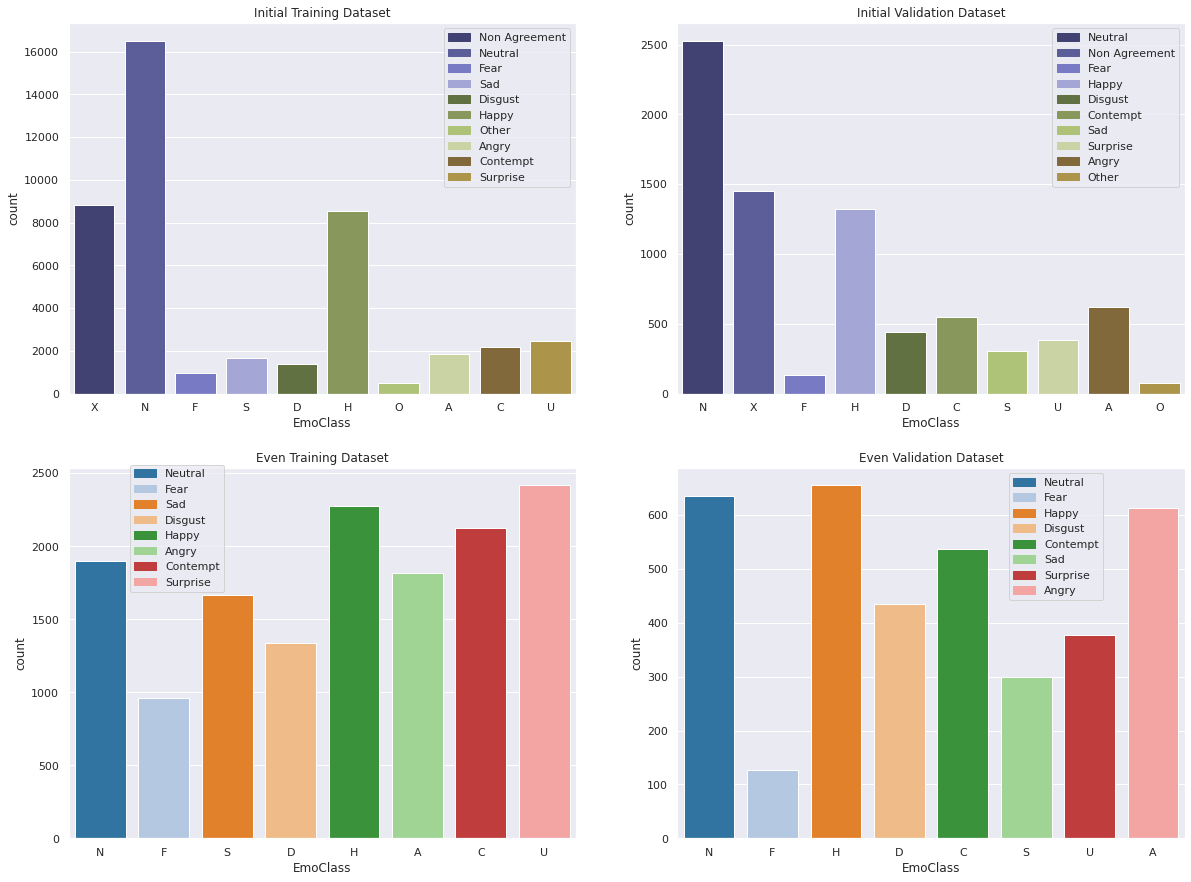

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

original_train_label_mappings = {
    'X': 'Non Agreement',
    'N': 'Neutral',
    'F': 'Fear',
    'S': 'Sad',
    'D': 'Disgust',
    'H': 'Happy',
    'O': 'Other',
    'A': 'Angry',
    'C': 'Contempt',
    'U': 'Surprise'
}

original_validation_label_mappings = {
    'N': 'Neutral',
    'X': 'Non Agreement',
    'F': 'Fear',
    'H': 'Happy',
    'D': 'Disgust',
    'C': 'Contempt',
    'S': 'Sad',
    'U': 'Surprise',
    'A': 'Angry',
    'O': 'Other'
}

refained_train_label_mappings = {
    'N': 'Neutral',
    'F': 'Fear',
    'S': 'Sad',
    'D': 'Disgust',
    'H': 'Happy',
    'A': 'Angry',
    'C': 'Contempt',
    'U': 'Surprise'
}

refained_validation_label_mappings = {
    'N': 'Neutral',
    'F': 'Fear',
    'H': 'Happy',
    'D': 'Disgust',
    'C': 'Contempt',
    'S': 'Sad',
    'U': 'Surprise',
    'A': 'Angry'
}

color_tab20b=['#414271', '#5c5e99', '#787ac3', '#a4a6d6', '#617141', '#88985c', '#afc378', '#c9d3a4', '#81693c', '#ac954a']

td = pd.read_csv('/content/drive/MyDrive/Data/Train.csv')
vd = pd.read_csv('/content/drive/MyDrive/Data/Validation.csv')


sns.set_theme(style="darkgrid")
f, axs = plt.subplots(2,2,figsize=(20,15))

labels = list(original_train_label_mappings.values())
handles = [plt.Rectangle((0,0),1,1, color=color_tab20b[label]) for label in range(len(labels))]
plt.subplot(2, 2, 1)
axs = sns.countplot(x=td['EmoClass'], data=td, palette='tab20b')
plt.legend(handles, labels, loc='upper right')
plt.title('Initial Training Dataset')

labels = list(original_validation_label_mappings.values())
handles = [plt.Rectangle((0,0),1,1, color=color_tab20b[label]) for label in range(len(labels))]
plt.subplot(2, 2, 2)
axs = sns.countplot(x=vd['EmoClass'], data=vd, palette='tab20b')
plt.legend(handles, labels, loc='upper right')
plt.title('Initial Validation Dataset')

color_tab20=['#3274a1', '#b5c8e1', '#e1812c', '#eebb89', '#3a923a', '#9fd495', '#c03d3e', '#f2a5a3']

td_fail = pd.read_csv('/content/drive/MyDrive/Data/Train_even_dataset.csv')
vd_fail = pd.read_csv('/content/drive/MyDrive/Data/Validation_even_dataset.csv')

labels = list(refained_train_label_mappings.values())
handles = [plt.Rectangle((0,0),1,1, color=color_tab20[label]) for label in range(len(labels))]
plt.subplot(2, 2, 3)
axs = sns.countplot(x=td_fail['EmoClass'], data=td_fail, palette='tab20')
plt.legend(handles, labels, bbox_to_anchor=(0.11, 0.65))
plt.title('Even Training Dataset')

labels = list(refained_validation_label_mappings.values())
handles = [plt.Rectangle((0,0),1,1, color=color_tab20[label]) for label in range(len(labels))]
plt.subplot(2, 2, 4)
axs = sns.countplot(x=vd_fail['EmoClass'], data=vd_fail, palette='tab20')
plt.legend(handles, labels, bbox_to_anchor=(0.85, 1.00))
plt.title('Even Validation Dataset')

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm_notebook

split_set = ['Train','Validation']
ceiling_value = [2500, 700]
fracs = [0.4, 0.4]
for split, sample_size in zip(split_set, fracs):
    print(f"{'-'*20} {split} Dataset {'-'*20}")
    split_df = pd.read_csv('/content/drive/MyDrive/Data/'+split+'.csv')
    print(f'Initial size: {len(split_df)}')
    split_df.drop(split_df.index[split_df['EmoClass'] == 'X'], inplace = True)
    split_df.drop(split_df.index[split_df['EmoClass'] == 'O'], inplace = True)
    print(f'Size after removing X (Non Agreement) and O (Other) labels: {len(split_df)}')

    split_df_sample = split_df.groupby('EmoClass', group_keys=False).apply(lambda x: x.sample(frac=sample_size)) # Get proportionate labels
    split_df_sample = split_df_sample.reset_index(drop=True)
    split_df_sample['Path'] = split_df_sample['Path'].str.replace('Podcast Data/Audios', '/content/drive/MyDrive/Data/Audio Files')
    bad_idxs=[]
    print(f'{round(sample_size*100)}% Sample size: {len(split_df_sample)}')
    for i in tqdm_notebook(range(len(split_df_sample.index))):
        try:
            with open(split_df_sample.loc[i, 'Path'], 'r') as f:
                pass
        except FileNotFoundError:
            bad_idxs.append(i)
    split_df_sample = split_df_sample.drop(bad_idxs)     
    split_df_sample = split_df_sample.reset_index(drop=True)
    print(f'Size after removing corrupt/missing files: {len(split_df_sample)}')
    split_df_sample = split_df_sample[['FileName', 'EmoClass', 'Path']].copy()
    new_fname = f'/content/drive/MyDrive/Data/{split}_failed_even_dataset.csv'
    split_df_sample.to_csv(new_fname, index=False)

# Train Models

## Preprocess Data

In [ ]:
data_files = {
    "train": "/content/drive/MyDrive/Data/Train_even_dataset.csv",
    "validation": "/content/drive/MyDrive/Data/Validation_even_dataset.csv"
}

dataset = load_dataset("csv", data_files=data_files, delimiter=",", cache_dir='/content/drive/MyDrive/Data/hugging/')
train_dataset = dataset["train"]
eval_dataset = dataset["validation"]

input_column = "Path"
output_column = "EmoClass"

label_list = train_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f'Total Labels:{num_labels}')

Using custom data configuration default-1699899898cfd524
Reusing dataset csv (/content/drive/MyDrive/Data/hugging/csv/default-1699899898cfd524/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e)


  0%|          | 0/2 [00:00<?, ?it/s]

Total Labels:8


## Sample Data to make sure nothing is corrupted

In [ ]:
import IPython.display as ipd
# 40 MOIAZEI ME PERANTONH FWNH
speech, sr = torchaudio.load(train_dataset[140]['Path'])
speech = speech[0].numpy().squeeze()
speech = librosa.resample(np.asarray(speech), sr, 16_000)
ipd.Audio(data=np.asarray(speech), autoplay=True, rate=16000)

In [ ]:
import IPython.display as ipd

target_sampling_rate = processor.feature_extractor.sampling_rate
speech_array, sampling_rate = torchaudio.load((train_dataset[140]['Path']))
resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
speech = resampler(speech_array).squeeze().numpy()
ipd.Audio(data=speech, autoplay=True, rate=16000)

## Prepare Model

In [ ]:
model_name_or_path = 'facebook/wav2vec2-base-960h'
pooling_mode = 'mean'


config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=num_labels,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
    problem_type="single_label_classification"
)

setattr(config, 'pooling_mode', pooling_mode)

processor = Wav2Vec2Processor.from_pretrained(model_name_or_path, return_attention_mask=True)
target_sampling_rate = processor.feature_extractor.sampling_rate

## Preprocess Data

In [ ]:
from tqdm.notebook import tqdm_notebook
import time

def speech_file_to_array_fn(path):
    speech_array, sampling_rate = torchaudio.load(path)
    resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
    speech = resampler(speech_array).squeeze().numpy()
    

    return speech


def label_to_id(label, label_list):
    if len(label_list) > 0:
        return label_list.index(label) if label in label_list else -1

    return label


def preprocess_function(examples):
    speech_list = [speech_file_to_array_fn(path) for path in examples[input_column]] 
    target_list = [label_to_id(label, label_list) for label in examples[output_column]]    


    result = processor(speech_list, sampling_rate=target_sampling_rate)
    result["labels"] = list(target_list)

    return result

In [ ]:
train_dataset = train_dataset.map(
    preprocess_function,
    batch_size=1,
    batched=True,
    num_proc=3
)

In [ ]:
eval_dataset = eval_dataset.map(
    preprocess_function,
    batch_size=1,
    batched=True,
    num_proc=3
)

## Save Processed data to drive

In [ ]:
import _pickle as cPickle

with open(r"/content/drive/MyDrive/Data/train_dataset2.pkl", "wb") as output_file:
    cPickle.dump(train_dataset, output_file)

with open(r"/content/drive/MyDrive/Data/eval_dataset2.pkl", "wb") as output_file:
    cPickle.dump(eval_dataset, output_file)


## Retrieve processed data from drive

In [ ]:
import _pickle as cPickle

with open("/content/drive/MyDrive/Data/train_dataset2.pkl", "rb") as input_file:
    train_dataset = cPickle.load(input_file)

with open('/content/drive/MyDrive/Data/eval_dataset2.pkl', "rb") as input_file:
    eval_dataset = cPickle.load(input_file)

In [ ]:
idx = 0
print(f"Training input_values: {train_dataset[idx]['input_values']}")
print(f"Training attention_mask: {train_dataset[idx]['attention_mask']}")
print(f"Training labels: {train_dataset[idx]['labels']} - {train_dataset[idx]['EmoClass']}")
# print(f'Training Total labels: {np.unique(train_dataset[:]['labels'])}')

## Model Architecture

In [ ]:
from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)


@dataclass
class SpeechClassifierOutput(ModelOutput):
    loss: Optional[torch.FloatTensor] = None
    logits: torch.FloatTensor = None
    hidden_states: Optional[Tuple[torch.FloatTensor]] = None
    attentions: Optional[Tuple[torch.FloatTensor]] = None


class Wav2Vec2ClassificationHead(nn.Module):
    """Head for wav2vec classification task."""

    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(config.final_dropout)
        self.out_proj = nn.Linear(config.hidden_size, config.num_labels)

    def forward(self, features, **kwargs):
        x = features
        x = self.dropout(x)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x


class Wav2Vec2ForSpeechClassification(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.pooling_mode = config.pooling_mode
        self.config = config

        self.wav2vec2 = Wav2Vec2Model(config)
        self.classifier = Wav2Vec2ClassificationHead(config)

        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs

    def forward(
            self,
            input_values,
            attention_mask=None,
            output_attentions=None,
            output_hidden_states=None,
            return_dict=None,
            labels=None,
    ):
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict
        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)
        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SpeechClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [feature["labels"] for feature in features]

        d_type = torch.long if isinstance(label_features[0], int) else torch.float

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )

        batch["labels"] = torch.tensor(label_features, dtype=d_type)

        return batch

## Trainer setup

The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

This data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them. This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)
is_regression = False

In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    if is_regression:
        return {"mse": ((preds - p.label_ids) ** 2).mean().item()}
    else:
        return {"accuracy": (preds == p.label_ids).astype(np.float32).mean().item()}

In [ ]:
model = Wav2Vec2ForSpeechClassification.from_pretrained(
    model_name_or_path,
    config=config
)

model.freeze_feature_extractor()

Downloading:   0%|          | 0.00/360M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForSpeechClassification: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSpeechClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSpeechClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'wav2vec2.masked_spec_embed', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a

In [ ]:
from transformers import TrainingArguments
from transformers import EarlyStoppingCallback

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Data/final_model_epoch/",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=2,
    evaluation_strategy="steps",
    save_strategy="steps",
    num_train_epochs=50,
    save_steps=round(len(train_dataset) * 0.1),  # len(train_dataset)*0.3
    eval_steps=round(len(train_dataset) * 0.1),
    logging_steps=round(len(train_dataset) * 0.1),
    learning_rate=1e-4,
    save_total_limit=2,
    metric_for_best_model='accuracy',
    load_best_model_at_end=True
)

from typing import Any, Dict, Union

import torch
from packaging import version
from torch import nn

from transformers import (
    Trainer,
    is_apex_available,
)

if is_apex_available():
    from apex import amp

if version.parse(torch.__version__) >= version.parse("1.6"):
    _is_native_amp_available = True
    from torch.cuda.amp import autocast


class CTCTrainer(Trainer):
    def training_step(self, model: nn.Module, inputs: Dict[str, Union[torch.Tensor, Any]]) -> torch.Tensor:
        """
        Perform a training step on a batch of inputs.

        Subclass and override to inject custom behavior.

        Args:
            model (:obj:`nn.Module`):
                The model to train.
            inputs (:obj:`Dict[str, Union[torch.Tensor, Any]]`):
                The inputs and targets of the model.

                The dictionary will be unpacked before being fed to the model. Most models expect the targets under the
                argument :obj:`labels`. Check your model's documentation for all accepted arguments.

        Return:
            :obj:`torch.Tensor`: The tensor with training loss on this batch.
        """

        model.train()
        inputs = self._prepare_inputs(inputs)

        if self.use_amp:
            with autocast():
                loss = self.compute_loss(model, inputs)
        else:
            loss = self.compute_loss(model, inputs)

        if self.args.gradient_accumulation_steps > 1:
            loss = loss / self.args.gradient_accumulation_steps

        if self.use_amp:
            self.scaler.scale(loss).backward()
        elif self.use_apex:
            with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                scaled_loss.backward()
        elif self.deepspeed:
            self.deepspeed.backward(loss)
        else:
            loss.backward()

        return loss.detach()



trainer = CTCTrainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor.feature_extractor,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import glob
list_of_files = glob.glob('/content/drive/MyDrive/Data/final_model_epoch/check*')
latest_checkpoint = max(list_of_files, key=os.path.getctime)
torch.cuda.empty_cache()
trainer.train(latest_checkpoint)

Loading model from /content/drive/MyDrive/Data/final_model_epoch/checkpoint-1014).
The following columns in the training set  don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: FileName, EmoClass, Path.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10141
  Num Epochs = 50
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 2
  Gradient Accumulation steps = 2
  Total optimization steps = 253500
  Continuing training from checkpoint, will skip to saved global_step
  Continuing training from epoch 0
  Continuing training from global step 1014
  Will skip the first 0 epochs then

  0%|          | 0/2028 [00:00<?, ?it/s]

Step,Training Loss,Validation Loss,Accuracy
2028,2.069600,2.068784,0.102993
3042,2.062100,2.047581,0.102993
4056,2.054100,2.071728,0.081228
5070,2.059900,2.038200,0.102993
6084,2.057800,2.048025,0.102993
7098,2.056300,2.035667,0.178002


The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: FileName, EmoClass, Path.
***** Running Evaluation *****
  Num examples = 2573
  Batch size = 1
Saving model checkpoint to /content/drive/MyDrive/Data/final_model_epoch/checkpoint-2028
Configuration saved in /content/drive/MyDrive/Data/final_model_epoch/checkpoint-2028/config.json
Model weights saved in /content/drive/MyDrive/Data/final_model_epoch/checkpoint-2028/pytorch_model.bin
Configuration saved in /content/drive/MyDrive/Data/final_model_epoch/checkpoint-2028/preprocessor_config.json
The following columns in the evaluation set  don't have a corresponding argument in `Wav2Vec2ForSpeechClassification.forward` and have been ignored: FileName, EmoClass, Path.
***** Running Evaluation *****
  Num examples = 2573
  Batch size = 1
Saving model checkpoint to /content/drive/MyDrive/Data/final_model_epoch/checkpoint-3042
Configuration saved in

KeyboardInterrupt: ignored

# Evaluation of the models

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
import pandas as pd
from tqdm.notebook import tqdm_notebook

In [ ]:
data_files={
    "Test1": "/content/drive/MyDrive/Data/Test1.csv",
    "Test2": "/content/drive/MyDrive/Data/Test2.csv"
}


for test in data_files:
  test_set = pd.read_csv(data_files[test])
  test_set = test_set[['FileName','EmoClass', 'EmoAct', 'EmoVal', 'EmoDom', 'Path']]
  test_set.dropna()
  test_set['Path'] = test_set['Path'].str.replace('Podcast Data/Audios', '/content/drive/MyDrive/Data/Audio Files')

  test_set.drop(test_set.index[test_set['EmoClass'] == 'X'], inplace = True)
  test_set.drop(test_set.index[test_set['EmoClass'] == 'O'], inplace = True)

  test_set = test_set.reset_index()
  test_set = test_set.groupby('EmoClass', group_keys=False).apply(lambda x: x.sample(frac=0.05)) 
  test_set = test_set.reset_index()
  bad_idxs=[]
  for i in tqdm_notebook(range(len(test_set.index))):  
    try:
      with open(test_set.loc[i, 'Path'], 'r') as f:
        pass
    except FileNotFoundError:
      bad_idxs.append(i)

  test_set = test_set.drop(bad_idxs)     
  test_set = test_set.reset_index(drop=True)
  test_set.to_csv(f'/content/drive/MyDrive/Data/{test}_refined.csv', index=True)

  0%|          | 0/606 [00:00<?, ?it/s]

  0%|          | 0/202 [00:00<?, ?it/s]

In [ ]:
model_name_or_path = '/content/drive/MyDrive/Data/final_model_epoch/checkpoint-7098'
config = AutoConfig.from_pretrained(model_name_or_path)
processor = Wav2Vec2Processor.from_pretrained('facebook/wav2vec2-base-960h', return_attention_mask=True)
target_sampling_rate = processor.feature_extractor.sampling_rate
model = Wav2Vec2ForSpeechClassification.from_pretrained(model_name_or_path)

In [ ]:
test_set.head()

,index,FileName,EmoClass,EmoAct,EmoVal,EmoDom,Path
0,0,MSP-PODCAST_0407_0049.wav,U,4.578947,3.315789,5.000000,/content/drive/MyDrive/Data/Audio Files/MSP-PO...
1,1,MSP-PODCAST_0407_0051.wav,A,5.222222,3.111111,5.333333,/content/drive/MyDrive/Data/Audio Files/MSP-PO...
2,2,MSP-PODCAST_0407_0071.wav,U,4.200000,3.400000,4.800000,/content/drive/MyDrive/Data/Audio Files/MSP-PO...
3,3,MSP-PODCAST_0407_0075.wav,N,5.411765,4.352941,5.235294,/content/drive/MyDrive/Data/Audio Files/MSP-PO...
4,4,MSP-PODCAST_0407_0099.wav,N,4.714286,4.285714,5.000000,/content/drive/MyDrive/Data/Audio Files/MSP-PO...


In [ ]:
data_files={
    "test1": "/content/drive/MyDrive/Data/Test1_refined.csv",
    "test2": "/content/drive/MyDrive/Data/Test2_refined.csv"
    }

dataset = load_dataset("csv", data_files=data_files, delimiter=",",)
test1_dataset = dataset["test1"]
test2_dataset = dataset["test2"]

input_column = "Path"
output_column = "EmoClass"

label_list = test1_dataset.unique(output_column)
label_list.sort()  # Let's sort it for determinism
num_labels = len(label_list)
print(f'Total Labels:{num_labels}')    

Using custom data configuration default-51e3fce40a6eec14


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-51e3fce40a6eec14/0.0.0/6b9057d9e23d9d8a2f05b985917a0da84d70c5dae3d22ddd8a3f22fb01c69d9e. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Total Labels:8


In [ ]:
from tqdm.notebook import tqdm_notebook
import time

def speech_file_to_array_fn(examples):
  speech_array, sampling_rate = torchaudio.load(examples[input_column])
  resampler = torchaudio.transforms.Resample(sampling_rate, target_sampling_rate)
  speech = resampler(speech_array).squeeze().numpy()
  
  examples["speech"] = speech_array
  return examples
  

def predict(examples):
  
  features = processor(examples['speech'], sampling_rate=processor.feature_extractor.sampling_rate, return_tensors="pt", padding=True)
  input_values = features.input_values
  attention_mask = features.attention_mask

  with torch.no_grad():
    logits = model(input_values, attention_mask=attention_mask).logits 
    pred_ids = torch.argmax(logits, dim=-1).detach().cpu().numpy()
    examples["predicted"] = pred_ids

  return examples

In [ ]:
test1_dataset = test1_dataset.map(
  speech_file_to_array_fn,
  num_proc=3
)  

In [ ]:
test2_dataset = test2_dataset.map(
    speech_file_to_array_fn,
    num_proc=3    
)

In [ ]:
from sklearn.metrics import classification_report

result1 = test1_dataset.map(
    predict,
    num_proc=3
)

label_names = [config.id2label[i] for i in range(config.num_labels)]
y_true = [config.label2id[name] for name in result1[output_column]]
y_pred = result1["predicted"]
print('\n')
print(classification_report(y_true, y_pred, target_names=label_names, zero_division=True))



              precision    recall  f1-score   support

           A       1.00      0.00      0.00        31
           C       1.00      0.00      0.00        37
           D       1.00      0.00      0.00        34
           F       1.00      0.00      0.00        16
           H       0.29      1.00      0.45       172
           N       1.00      0.00      0.00       222
           S       1.00      0.00      0.00        23
           U       1.00      0.00      0.00        51

    accuracy                           0.29       586
   macro avg       0.91      0.12      0.06       586
weighted avg       0.79      0.29      0.13       586



In [ ]:
from sklearn.metrics import classification_report

result2 = test2_dataset.map(
    predict,
    num_proc=3
)

label_names = [config.id2label[i] for i in range(config.num_labels)]
y_true = [config.label2id[name] for name in result2[output_column]]
y_pred = result2["predicted"]
print('\n')
print(classification_report(y_true, y_pred, target_names=label_names, zero_division=True))



              precision    recall  f1-score   support

           A       1.00      0.00      0.00         7
           C       1.00      0.00      0.00         9
           D       1.00      0.00      0.00         4
           F       1.00      0.00      0.00         4
           H       0.23      1.00      0.37        46
           N       1.00      0.00      0.00       113
           S       1.00      0.00      0.00         8
           U       1.00      0.00      0.00        11

    accuracy                           0.23       202
   macro avg       0.90      0.12      0.05       202
weighted avg       0.82      0.23      0.08       202

